# Imports

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
import h2o
from h2o.automl import H2OAutoML
from matplotlib import pyplot as plt
h2o.init()

warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 26 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,"14 days, 4 hours and 53 minutes"
H2O_cluster_name:,H2O_from_python_hansstem_ce8mbw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.471 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


# Load datasets

In [38]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [39]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [40]:
print(XTRA["date_forecast"].head())
print(YA["time"].head())


0   2019-06-02 22:00:00
1   2019-06-02 22:15:00
2   2019-06-02 22:30:00
3   2019-06-02 22:45:00
4   2019-06-02 23:00:00
Name: date_forecast, dtype: datetime64[ns]
0   2019-06-02 22:00:00
1   2019-06-02 23:00:00
2   2019-06-03 00:00:00
3   2019-06-03 01:00:00
4   2019-06-03 02:00:00
Name: time, dtype: datetime64[ns]


# Data clean up

In [41]:
start_times_b = [
    '2019-03-24 00:00:00',
'2019-05-31 00:00:00',
'2019-10-28 14:00:00',
'2020-02-23 17:00:00',
'2020-03-26 14:00:00',
'2020-04-02 03:00:00',
'2020-07-12 23:00:00',
'2020-09-24 14:00:00',
'2021-01-15 10:00:00',
'2021-04-29 00:00:00',
'2021-06-05 03:00:00',
'2021-06-13 04:00:00',
'2021-06-22 03:00:00',
'2021-07-03 15:00:00',
'2021-08-26 00:00:00',
'2021-09-08 15:00:00',
'2021-09-19 02:00:00',
'2021-01-30 15:00:00',
'2022-02-10 21:00:00',
'2022-02-16 14:00:00',
'2022-03-19 15:00:00',
'2022-12-05 17:00:00',
'2023-02-24 01:00:00',
'2023-03-07 10:00:00',
'2023-03-25 23:00:00'
]

end_times_b = [
    '2019-03-28 00:00:00',
'2019-06-03 14:00:00',
'2019-10-30 23:00:00',
'2020-03-06 06:00:00',
'2020-03-27 22:00:00',
'2020-04-16 08:00:00',
'2020-08-25 23:00:00',
'2020-09-25 23:00:00',
'2021-04-19 09:00:00',
'2021-05-01 23:00:00',
'2021-06-07 08:00:00',
'2021-06-14 10:00:00',
'2021-06-24 08:00:00',
'2021-07-06 07:00:00',
'2021-09-03 22:00:00',
'2021-09-14 13:00:00',
'2021-09-27 10:00:00',
'2022-02-04 09:00:00',
'2022-02-13 07:00:00',
'2022-02-24 06:00:00',
'2022-04-13 06:00:00',
'2023-01-05 08:00:00',
'2023-02-27 05:00:00',
'2023-03-10 01:00:00',
'2023-03-28 02:00:00'
]

print("before B drop: ", len(YB))

for i in range(len(start_times_b)):
    a = pd.to_datetime(start_times_b[i])
    b = pd.to_datetime(end_times_b[i])
    ind = YB[ (YB['time'] >= a) & (YB['time'] <= b)].index
    
    YB.drop(ind, inplace=True)

print("after B drop: ", len(YB))

print("before C drop: ", len(YC))

a = pd.to_datetime("2020-02-23 17:00:00")
b = pd.to_datetime('2020-03-08 08:00:00')
ind = YC[ (YC['time'] >= a) & (YC['time'] <= b)].index
    
YC.drop(ind, inplace=True)
print("after C drop: ", len(YC))


before B drop:  32848
after B drop:  20628
before C drop:  32155
after C drop:  31827


In [42]:
import data_func.aggregation as data_agg


In [43]:
for x in X_frames_test:
    print(x["date_forecast"].head())

for i in range(len(X_frames_test)):
    X_frames_test[i] = X_frames_test[i].drop([0]).reset_index(drop=True)


0   2023-05-01 00:00:00
1   2023-05-01 00:15:00
2   2023-05-01 00:30:00
3   2023-05-01 00:45:00
4   2023-05-01 01:00:00
Name: date_forecast, dtype: datetime64[ns]
0   2023-05-01 00:00:00
1   2023-05-01 00:15:00
2   2023-05-01 00:30:00
3   2023-05-01 00:45:00
4   2023-05-01 01:00:00
Name: date_forecast, dtype: datetime64[ns]
0   2023-05-01 00:00:00
1   2023-05-01 00:15:00
2   2023-05-01 00:30:00
3   2023-05-01 00:45:00
4   2023-05-01 01:00:00
Name: date_forecast, dtype: datetime64[ns]


In [44]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median)
   mean = data_agg.gen_agg(mean, "mean")

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])




In [45]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))



x,y:  29667 29667
x,y:  17161 17161
x,y:  22813 22813


# Feature engineering

In [46]:
import data_func.timeseasonality as DTS
import data_func.date_forecast as DTF
import data_func.one_hot_encoding as OHE

categorical_features = ['dew_or_rime:idx', 'precip_type_5min:idx']


for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DTF.date_forecast_columns(X_train[i])
    X_train[i] = OHE.one_hot_encode(X_train[i], categorical_features)
    X_train[i].drop(columns=['snow_drift:idx'], inplace=True)


for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DTF.date_forecast_columns(X_frames_test[i])
    X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], categorical_features)
    X_frames_test[i].drop(columns=['snow_drift:idx'], inplace=True)


print(len(X_train[0]), len(X_train[1]), len(X_train[2]))
print(len(X_frames_test[0]), len(X_frames_test[1]), len(X_frames_test[2]))



29667 17161 22813
720 720 720


In [47]:
X_train[0].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
is_day:idx,29667.0,0.471500,0.499196,0.000000,0.000000,0.000000e+00,1.000000,1.000000e+00
is_in_shadow:idx,29667.0,0.496174,0.499994,0.000000,0.000000,0.000000e+00,1.000000,1.000000e+00
absolute_humidity_2m:gm3,29667.0,6.379581,2.612027,0.700000,4.400000,5.975000e+00,8.100000,1.605000e+01
air_density_2m:kgm3,29667.0,1.252307,0.034827,1.145000,1.229000,1.251000e+00,1.274000,1.426250e+00
ceiling_height_agl:m,24681.0,3043.045898,2555.343994,27.849998,1183.925049,2.080000e+03,4255.549805,1.228565e+04
clear_sky_energy_1h:J,29667.0,565528.562500,825693.562500,0.000000,0.000000,4.782730e+04,959101.687500,2.988628e+06
clear_sky_rad:W,29667.0,157.091171,229.956268,0.000000,0.000000,1.325000e+01,273.575012,8.351000e+02
cloud_base_agl:m,28055.0,1746.576660,1822.560547,27.900000,598.125000,1.160900e+03,2088.106201,1.167362e+04
dew_point_2m:K,29667.0,276.139557,6.374989,251.074997,271.875000,2.760500e+02,280.924988,2.919500e+02
diffuse_rad:W,29667.0,42.953587,61.441681,0.000000,0.000000,6.162500e+00,72.262501,3.322750e+02


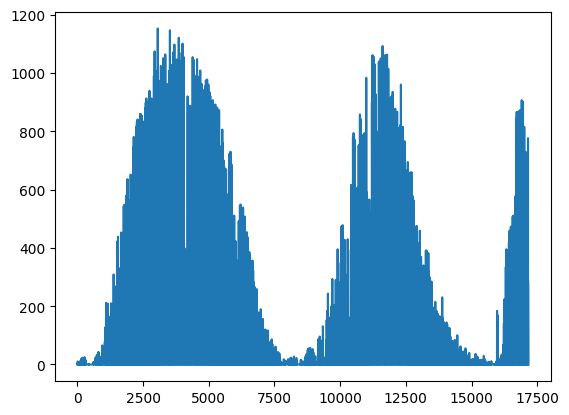

In [73]:

def merge(df1, df2):
    return pd.merge(df1, df2, left_index=True, right_index=True)

x_train_a = merge(X_train[0], Y_train[0])
x_train_b = merge(X_train[1], Y_train[1])
x_train_c = merge(X_train[2], Y_train[2])

plt.plot(Y_train[1])



In [48]:



# Data set A, B and C to H2O

def data_to_h2o(x_train, y_train, x_test):
  
    x_train_h2o = h2o.H2OFrame(x_train)
    y_train = y_train.to_frame()
    y_train_h2o = h2o.H2OFrame(y_train)
    x_test_h2o = h2o.H2OFrame(x_test)
  
    return x_train_h2o, y_train_h2o, x_test_h2o



x_train_a_h2o, y_train_a_h2o, x_test_a_h2o = data_to_h2o(x_train_a, Y_train[0], X_frames_test[0])
x_train_b_h2o, y_train_b_h2o, x_test_b_h2o = data_to_h2o(x_train_a, Y_train[1], X_frames_test[1])
x_train_c_h2o, y_train_c_h2o, x_test_c_h2o = data_to_h2o(x_train_a, Y_train[2], X_frames_test[2])
y_train_a_h2o.head()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


pv_measurement
0
0
0
0
19.36
251.02
263.78
522.72
904.42
1238.82


# Training the model

In [49]:
print(y_train_a_h2o)
aml_a = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)
aml_b = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)
aml_c = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)

aml_a.train(x=x_train_a_h2o.columns, y=y_train_a_h2o.columns[0], training_frame=x_train_a_h2o)
aml_b.train(x=x_train_b_h2o.columns, y=y_train_b_h2o.columns[0], training_frame=x_train_b_h2o)
aml_c.train(x=x_train_c_h2o.columns, y=y_train_c_h2o.columns[0], training_frame=x_train_c_h2o)



  pv_measurement
            0
            0
            0
            0
           19.36
          251.02
          263.78
          522.72
          904.42
         1238.82
[29667 rows x 1 column]

AutoML progress: |


15:20:04.210: AutoML: XGBoost is not available; skipping it.
15:20:04.212: _train param, Dropping bad and constant columns: [elevation:m]


15:20:05.9: _train param, Dropping bad and constant columns: [elevation:m]

██████
15:20:23.73: _train param, Dropping bad and constant columns: [elevation:m]

██
15:21:07.972: _train param, Dropping bad and constant columns: [elevation:m]

█
15:21:19.30: _train param, Dropping bad and constant columns: [elevation:m]

██
15:21:32.515: _train param, Dropping bad and constant columns: [elevation:m]

██
15:21:47.694: _train param, Dropping bad and constant columns: [elevation:m]

██
15:22:42.379: _train param, Dropping bad and constant columns: [elevation:m]

█
15:22:53.9: _train param, Dropping bad and constant columns: [elevation:m]

███
15:23:06.187: _train param, Dropping unused columns: [elevation:m]

██
15:23:06.880: _train param, Dropping unused columns: [elevation:m]

██████████████████████████████████████████| (done) 100%
AutoML progress: |


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/10
# GBM base models (used / total),4/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


# Evaluate training

In [50]:
lb = aml_a.leaderboard
lb.head(rows=lb.nrows) 



model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_10_20231030_152004,373.982,139863,175.01,nan,139863
GBM_4_AutoML_10_20231030_152004,381.767,145746,177.761,nan,145746
StackedEnsemble_BestOfFamily_1_AutoML_10_20231030_152004,381.889,145839,178.743,nan,145839
GBM_3_AutoML_10_20231030_152004,384.994,148221,181.008,nan,148221
GBM_grid_1_AutoML_10_20231030_152004_model_1,386.308,149234,180.456,nan,149234
GBM_2_AutoML_10_20231030_152004,391.843,153541,185.06,nan,153541
GBM_5_AutoML_10_20231030_152004,397.97,158380,190.134,nan,158380
GBM_1_AutoML_10_20231030_152004,401.229,160984,190.639,nan,160984
DRF_1_AutoML_10_20231030_152004,412.562,170207,192.493,0.753619,170207
XRT_1_AutoML_10_20231030_152004,414.625,171914,193.842,0.766426,171914


# Make predictions

In [51]:
y_pred_a = aml_a.leader.predict(x_test_a_h2o)
y_pred_b = aml_b.leader.predict(x_test_b_h2o)
y_pred_c = aml_c.leader.predict(x_test_c_h2o)

y_pred_a = y_pred_a.as_data_frame()
y_pred_b = y_pred_b.as_data_frame()
y_pred_c = y_pred_c.as_data_frame()

y_pred = pd.concat([y_pred_a, y_pred_b, y_pred_c], axis=0, ignore_index=True)


stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'dew_or_rime:idx_-1': substituting in a column of NaN
  warnings.warn(w)
/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'precip_type_5min:idx_2': substituting in a column of NaN
  warnings.warn(w)
/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'precip_type_5min:idx_3': substituting in a column of NaN
  warnings.warn(w)
/Users/hansstem/.conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'precip_type_5min:idx_5': substituting in a column of NaN
  warnings.warn(w)


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [52]:
varimp = aml_a.varimp(use_pandas=True)
print(varimp)


                         DeepLearning_1         GBM_1         XRT_1  \
direct_rad_1h:J                0.023064  2.442481e-02  1.991813e-01   
clear_sky_rad:W                0.019669  7.468256e-02  7.822007e-02   
sun_elevation:d                0.015023  1.184782e-01  1.064618e-01   
diffuse_rad:W                  0.011375  2.694523e-02  3.920222e-02   
clear_sky_energy_1h:J          0.021629  4.975648e-03  3.487606e-02   
year                           0.018234  1.000579e-02  5.939144e-03   
sinus_year                     0.015626  5.517787e-03  4.184865e-03   
cloud_base_agl:m               0.015584  2.591815e-03  4.166603e-03   
t_1000hPa:K                    0.018938  3.970766e-03  3.847384e-03   
air_density_2m:kgm3            0.018909  3.891033e-03  3.617345e-03   
day                            0.011821  5.838319e-03  4.851534e-03   
wind_speed_10m:ms              0.012190  4.751831e-03  5.040194e-03   
precip_5min:mm                 0.015561  3.697328e-03  2.458642e-03   
dew_po

# Create submission

(2160, 1)

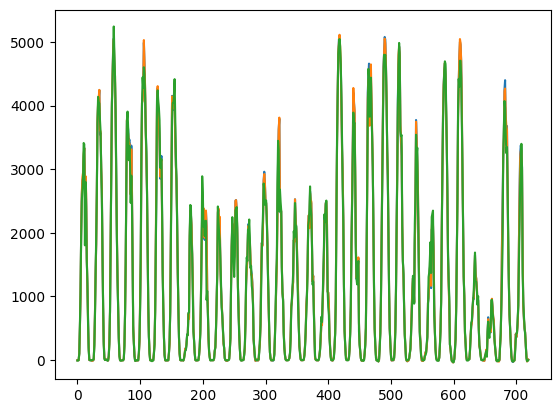

In [71]:
plt.plot(y_pred_a)
plt.plot(y_pred_b)
plt.plot(y_pred_c)
y_pred.shape


In [54]:
test = pd.read_csv('../data/test.csv')
test['prediction'] = y_pred['predict']
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_h2o.csv', index=False)
